In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from pdb import set_trace
import glob
from collections import Counter

In [192]:
ls

README.md  figs/      library/   notebooks/


cd ..

### ADD PLAYER STATS DF

In [193]:
player_stats_file = 'library/Blueprint 2019 Players.csv'
player_stats_df = pd.read_csv(player_stats_file)

#change all columns to numeric
column_list = ['Total completed throw distance (m)','Total completed throw gain (m)',
                 'Total caught pass distance (m)']

for i in column_list:
    player_stats_df[i] = [x.replace(',','') for x in player_stats_df[i]]
    player_stats_df[i] = pd.to_numeric(player_stats_df[i])             

#change index to payer name
player_stats_df = player_stats_df.set_index('Player')

#create player inits column
players = list(player_stats_df.index)
player_inits = []
for p in players:
    try:
        player_init = p.split(' ')[0][0] + p.split(' ')[1][0]
    except IndexError:
        player_init = p.split(' ')[0][:2]
    player_inits.append(player_init)
    
player_stats_df['player_inits'] = player_inits

#create a a new position_df to host player names and positions. will merge with player_df later
position_df = pd.DataFrame(columns=['Player','Position'])
position_df['Player'] = list(player_stats_df.index)
#manually enter all positions for players
position_df['Position'] = ['C','C','C','H','C','H','C','C','C','C','H','C','C','H','C','C','H','C','H','H',
                           'C','C','H','C','C','H','C','H']

#create a column for pecent of total points played that are offensive points
player_stats_df['percent_Opp'] = player_stats_df['Offense points played'] / player_stats_df['Points played total']

#assign players as 'offense', 'defense', or 'flex'
#assignment is split into thirds of playing time
#ex: < .33 of total points played on offense = 'defense'
#'flex' is the middle third
player_stats_df['Line'] = ['Off' if x >= .66 else 'def' if x < .33 else 'Flex' 
                           for x in player_stats_df['percent_Opp']]

#set player to index of position_df
position_df = position_df.set_index('Player')

#join position and player stats on the index of player
player_stats_df = player_stats_df.join(position_df)

player_stats_df.reset_index(inplace=True)

### COMBINE GAMExGAME POSSESSION DATA INTO ONE POSS_DF

In [194]:
#give file path abbreviation
poss_path_abbr = 'library/possessions/Possessions vs.*.csv'
#create list of files that match the possession convention
file_list = glob.glob(poss_path_abbr)
#create an empty df
poss_df = pd.DataFrame()
#loop through each file in the list
for file in file_list:
    #add an oppnent depending on the name of the file
    opponent = file.split('vs. ')[1].split(' 2019')[0]
    df_ = pd.read_csv(file)
    #add oppenent name column
    df_['opponent'] = opponent
    #append file to the overall poss_df
    poss_df = poss_df.append(df_)

### COMBINE GAMExGAME PASSES DATA INTO ONE PASSES_DF

In [195]:
#give file path abbreviation
passes_path_abbr = 'library/passes/Passes vs.*.csv'
#create list of files that match the passes convention
file_list = glob.glob(passes_path_abbr)
#create an empty df
passes_df = pd.DataFrame()
#loop through each file in the list
for file in file_list:
    #add an oppnent depending on the name of the file
    opponent = file.split('vs. ')[1].split(' 2019')[0]
    df_ = pd.read_csv(file)
    #add oppenent name column
    df_['opponent'] = opponent
    #append file to the overall passes_df
    passes_df = passes_df.append(df_)

#remove all of the empty data with no thrower nor reciever
passes_df = passes_df.dropna(subset=['Thrower', 'Receiver'])

### MERGE THE PASSES_DF WITH THE POSS_DF AND PLAYER_STATS_DF (player info only)

In [196]:
full_poss_df = pd.merge(passes_df,poss_df,how='left',on=['Point','Possession','opponent'],copy=False)
full_poss_df = full_poss_df.reset_index(drop=True)
full_poss_df = full_poss_df.drop(columns=['Created_y','Start X (0 -> 1 = left sideline -> right sideline)_y',
                  'Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)_y'])

In [197]:
full_poss_df.columns = [x.replace('_x','') for x in full_poss_df.columns]

In [198]:
#create a unique posession index based on opponent, point#, possession#
for x in full_poss_df.index:
    full_poss_df.loc[x,'possession_index'] = full_poss_df.loc[x,'opponent'] + ' | ' + \
    str(full_poss_df.loc[x,'Point']) + '.' + \
    str(full_poss_df.loc[x,'Possession'])

In [199]:
#write to CSV
full_poss_df.to_csv('library/possessions/BP_2019_Full_Possession_Data.csv')

In [200]:
#add player info columns for each column that has a name
#list of cols that have a name
name_cols = ['Thrower','Receiver','Initiator','Secondary assist','Assist','Goal','Thrower error',
             'Receiver error']
#for loop to add line and position by merging in player_stats_df
for i in name_cols:
    full_poss_df = (full_poss_df
                     .merge(player_stats_df[['Player','Line','Position']],
                            left_on=i,right_on='Player',how='left')
                     .drop(columns='Player')
                     .rename(columns={'Line':f'{i}_line','Position':f'{i}_position'}))

### EXPLORATORY DATA ANALYSIS

### IDEAS
Could you take out the initiation throws to balance everything out for people who don't get those chances?
Scoring percentage split by position and line
~KDE plot of positions on field
~Most prolific thrower,receiver combos
Percent of throws as scores?
Percent of throws as good outcomes?
~Longest Point as an explanatory point
Angle of throw relative to goal line?
What is the expected points added for a given throw?
- Each throw increases/decreases chances of scoring by gaining/loswing yards
- Each throw has a chance of being a turnover
- How much does a turnover hurt our chance of scoring?
- Expected points added for each throw

If I was presenting this to the team, what kind of analysis would I give?
- Individual player feedback
    - 
- Team feedback
    - Chance of scoring for each position on the field
    - Assign a value to each throw based on where it went, comp rate, receiver ...

### EXPLANATORY POINT

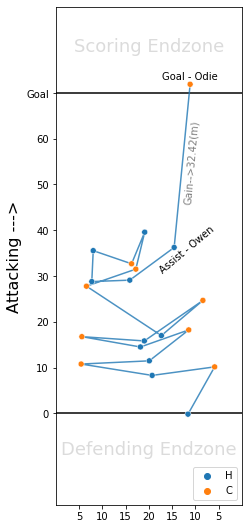

In [856]:
#Longest successful point
#https://youtu.be/lvYYeYSNwL4?t=1623
fig, ax = plt.subplots(figsize=(4/1.2,11/1.2))
#sns.despine(left=True,bottom=False,top=False)

df = full_poss_df.copy()
df = df[ (df['Passes'] == df['Passes'].max()) & (df['Point'] == 18)]

x = (df['Start X (0 -> 1 = left sideline -> right sideline)'].append( 
       pd.Series(df['End X (0 -> 1 = left sideline -> right sideline)'].iloc[-1])))
y = 1 - (df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].append( 
     pd.Series(df['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)'].iloc[-1])))
hue = df['Thrower_position'].append(pd.Series(df['Receiver_position'].iloc[-1]))

grid = sns.lineplot(x=x,y=y,alpha=.8,sort=False,ax=ax,zorder=1)
sns.scatterplot(x=x,y=y,alpha=1,hue=hue,zorder=2)



#make field
c = 'k'
grid.axvline(x=0,color=c,alpha=0)
grid.axvline(x=1,color=c,alpha=0)
grid.axhline(y=0,color=c,alpha=0)
grid.axhline(y=.1818181818,color=c,zorder=0)
grid.axhline(y=.8181818181,color=c,zorder=0)
grid.axhline(y=.99,color=c,alpha=0)
grid.margins(x=0,y=0)

#set x and yticks as yard markers every 10 yards
xtick = .25/2
ytick = .181818/2
grid.set_xticks([xtick,xtick*2,xtick*3,xtick*4,xtick*5,xtick*6,xtick*7])
grid.set_xticklabels([5,10,15,20,15,10,5])
grid.set_yticks([ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9])
grid.set_yticklabels([0,10,20,30,40,50,60,'Goal'])

grid.set_xlabel('')
grid.set_ylabel('Attacking --->',fontsize=16)

#annotate endzones
grid.text(.50,.9,'Scoring Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)
grid.text(.50,.1,'Defending Endzone',
          ha='center',color='lightgray',alpha=.8,fontsize=18)

#annotate names
goal = df.iloc[-1]
#goal
grid.text(goal['End X (0 -> 1 = left sideline -> right sideline)'],
          (1-goal['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) + .01,
          'Goal - {}'.format(df.iloc[-1]['Receiver'].split(' ')[0]),
          ha='center')
#assist
grid.text(goal['Start X (0 -> 1 = left sideline -> right sideline)']+.07,
          (1-goal['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']) - .05,
          'Assist - {}'.format(df.iloc[-1]['Thrower'].split(' ')[0]),
          ha='center',rotation=40)
#length
grid.text(.73,.6,
          'Gain-->{}(m)'.format(df.iloc[-1]['Forward distance (m)'].round(2)),
          ha='center',rotation=85,color='gray')

ax.legend(loc='lower right')
plt.show()

### CHANCE OF SCORING FOR EACH BIN ON THE FIELD

### INDIVIDUAL PLAYER ANALYSIS

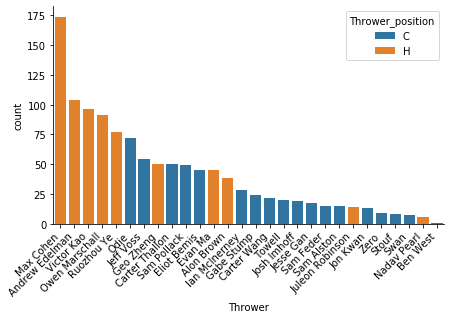

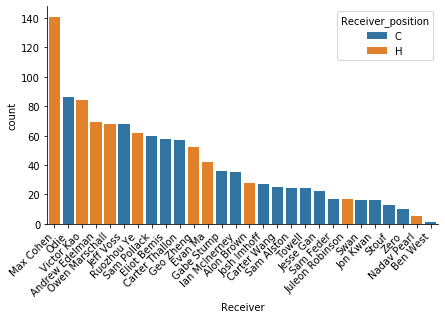

In [202]:
def count_plot(column):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.despine(fig)

    col = column
    df = full_poss_df.copy()

    sns.countplot(x=df[col],hue=f'{col}_position',order=df[col].value_counts(ascending=False).index,data=df,
                  hue_order=['C','H'],dodge=False)

    ax.set_xticks(range(len(df[col].value_counts(ascending=False).index)))
    ax.set_xticklabels(df[col].value_counts(ascending=False).index,rotation=45,ha='right')

    return plt.show()
    
count_plot('Thrower')
count_plot('Receiver')

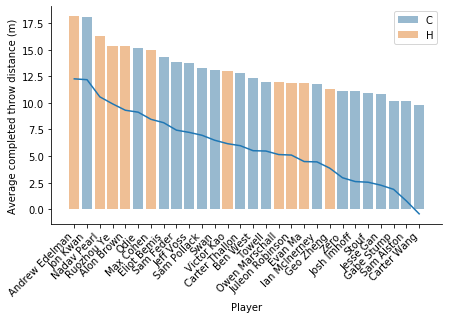

In [203]:
fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()

x = 'Player'
y1 = 'Average completed throw distance (m)'
y2 = 'Average completed throw gain (m)'
sns.barplot(data=df.sort_values(by=y1,ascending=False),x=x,y=y1,hue='Position',hue_order=['C','H'],
            dodge=False,alpha=.5)
sns.lineplot(data=df.sort_values(by=y2,ascending=False),x=x,y=y2)

ax.set_xticks(range(len(df.sort_values(by=y1,ascending=False).index)))
ax.set_xticklabels(df.sort_values(by=y1,ascending=False)['Player'],rotation=45,ha='right')

plt.show()

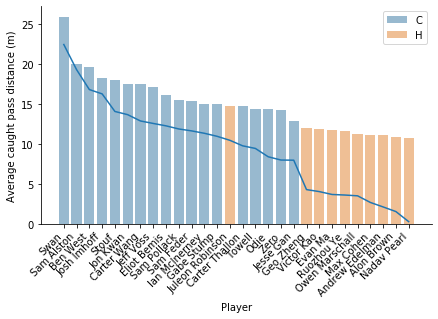

In [204]:
fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()

x = 'Player'
y1 = 'Average caught pass distance (m)'
y2 = 'Average caught pass gain (m)'
sns.barplot(data=df.sort_values(by=y1,ascending=False),x=x,y=y1,hue='Position',hue_order=['C','H'],
            dodge=False,alpha=.5)
sns.lineplot(data=df.sort_values(by=y2,ascending=False),x=x,y=y2)

ax.set_xticks(range(len(df.sort_values(by=y1,ascending=False).index)))
ax.set_xticklabels(df.sort_values(by=y1,ascending=False)['Player'],rotation=45,ha='right')

plt.show()

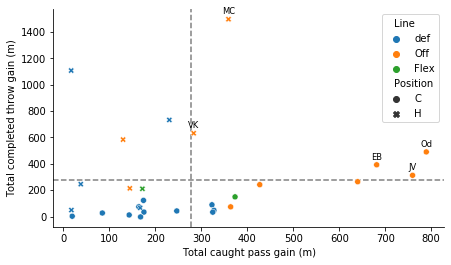

In [794]:
#grid plot of throwing gain by distance
fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()

x = 'Player'
y1 = 'Total caught pass gain (m)'
y2 = 'Total completed throw gain (m)'

pl = sns.scatterplot(data=df.sort_values(by=y2,ascending=False),x=y1,y=y2,
                     hue='Line',hue_order=['def','Off','Flex'],
                     style='Position',style_order=['C','H'])

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

ann = (df[ (df[y2] > df[y2].mean()) & (df[y1] > df[y1].mean())]
       .reset_index(drop=True))
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i],ann[y2][i]+40,ann['player_inits'][i],ha='center',size='small')

plt.show()

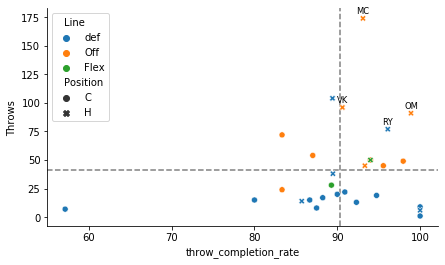

In [518]:
#compare completion percentage with volume
fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()
df['throw_completion_rate'] = ((1 - (df['Thrower errors'] / df['Throws'])) * 100).round(decimals=2)

x = 'Player'
y1 = 'throw_completion_rate'
y2 = 'Throws'

pl = sns.scatterplot(data=df,x=y1,y=y2,
                     hue='Line',hue_order=['def','Off','Flex'],
                     style='Position',style_order=['C','H'])

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

ann = (df[ (df[y1] > df[y1].mean()) & (df[y2] > df[y2].mean()+10)]
       .reset_index(drop=True))
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i],ann[y2][i]+4,ann['player_inits'][i],ha='center',size='small')

plt.show()

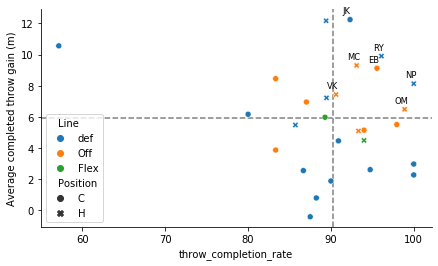

In [682]:
#compare completion percentage with average throw gain
fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()
df['throw_completion_rate'] = ((1 - (df['Thrower errors'] / df['Throws'])) * 100).round(decimals=2)

x = 'Player'
y1 = 'throw_completion_rate'
y2 = 'Average completed throw gain (m)'

pl = sns.scatterplot(data=df,x=y1,y=y2,
                     hue='Line',hue_order=['def','Off','Flex'],
                     style='Position',style_order=['C','H'])

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

ann = (df[ (df[y1] > df[y1].mean()) & (df[y2] > df[y2].mean())]
       .reset_index(drop=True))
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i]-.4,ann[y2][i]+.4,ann['player_inits'][i],ha='center',size='small')

plt.show()

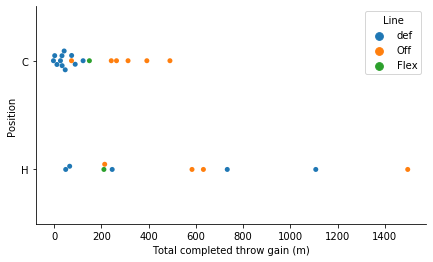

In [222]:
#swarm plot of throw gain by position and line
fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

df = player_stats_df.copy()

x = 'Player'
y1 = 'Total caught pass distance (m)'
y2 = 'Total completed throw gain (m)'

pl = sns.swarmplot(data=df,x=y2,y='Position',hue='Line')

#ax.set_xticks(range(len(df.sort_values(by=y1,ascending=False).index)))
#ax.set_xticklabels(df.sort_values(by=y1,ascending=False)['Player'],rotation=45,ha='right')

plt.show()

### Most Prolific Player Pairs

In [540]:
full_poss_df.columns

Index(['Created', 'Point', 'Possession', 'Thrower', 'Receiver', 'Turnover?',
       'Thrower error?', 'Receiver error?', 'Throw to endzone?', 'Assist?',
       'Secondary assist?', 'Huck?', 'Swing?', 'Dump?', 'From sideline?',
       'To sideline?', 'Distance (m)', 'Forward distance (m)',
       'Left-to-right distance (m)',
       'Start X (0 -> 1 = left sideline -> right sideline)',
       'Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)',
       'End X (0 -> 1 = left sideline -> right sideline)',
       'End Y (0 -> 1 = back of opponent endzone -> back of own endzone)',
       'opponent', 'Started point on offense?', 'Scored?', 'Initiator',
       'Passes', 'Secondary assist', 'Assist', 'Goal', 'Thrower error',
       'Receiver error', 'Stalled out', 'possession_index', 'Thrower_line',
       'Thrower_position', 'Receiver_line', 'Receiver_position',
       'Initiator_line', 'Initiator_position', 'Secondary assist_line',
       'Secondary assist_position', 'Assist_

In [647]:
pairs = (full_poss_df.groupby(['Thrower','Receiver'])
 .agg({'Distance (m)':['count','mean','sum'],'Forward distance (m)':['mean','sum']})
 .sort_values(by=[('Forward distance (m)','sum')],ascending=False).reset_index())
pairs.columns = pairs.columns.droplevel(level=1)
pairs.columns = ['Thrower','Receiver','Count','Distance_mean','Distance_sum',
                 'Gain_mean','Gain_sum']
pairs = (pairs.merge(player_stats_df[['Player','player_inits']],left_on='Thrower',right_on='Player',how='left')
 .merge(player_stats_df[['Player','player_inits']],left_on='Receiver',right_on='Player',how='left'))
pairs

,Thrower,Receiver,Count,Distance_mean,Distance_sum,Gain_mean,Gain_sum,Player_x,player_inits_x,Player_y,player_inits_y
0,Max Cohen,Jeff Voss,21,20.043853,420.920908,16.659940,349.858746,Max Cohen,MC,Jeff Voss,JV
1,Max Cohen,Sam Pollack,19,17.135931,325.582693,14.209782,269.985861,Max Cohen,MC,Sam Pollack,SP
2,Andrew Edelman,Swan,9,33.528399,301.755591,29.896423,269.067803,Andrew Edelman,AE,Swan,Sw
3,Max Cohen,Eliot Bemis,16,18.336040,293.376639,15.898659,254.378537,Max Cohen,MC,Eliot Bemis,EB
4,Odie,Jeff Voss,10,27.615155,276.151550,25.120056,251.200561,Odie,Od,Jeff Voss,JV
...,...,...,...,...,...,...,...,...,...,...,...
310,Jon Kwan,Alon Brown,3,9.239760,27.719279,-3.884181,-11.652544,Jon Kwan,JK,Alon Brown,AB
311,Jeff Voss,Max Cohen,13,10.901235,141.716058,-0.939810,-12.217525,Jeff Voss,JV,Max Cohen,MC
312,Geo Zheng,Andrew Edelman,7,9.240398,64.682789,-2.158998,-15.112989,Geo Zheng,GZ,Andrew Edelman,AE
313,Towell,Andrew Edelman,7,10.947760,76.634323,-2.865213,-20.056490,Towell,To,Andrew Edelman,AE


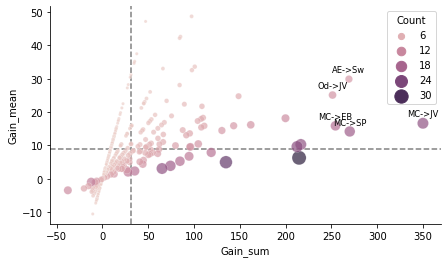

In [681]:
#compare completion percentage with average throw gain
fig, ax = plt.subplots(figsize=(7,4))
sns.despine(fig)

#get list of pairs
pairs = (full_poss_df.groupby(['Thrower','Receiver'])
 .agg({'Distance (m)':['count','mean','sum'],'Forward distance (m)':['mean','sum']})
 .sort_values(by=[('Forward distance (m)','sum')],ascending=False).reset_index())
pairs.columns = pairs.columns.droplevel(level=1)
pairs.columns = ['Thrower','Receiver','Count','Distance_mean','Distance_sum',
                 'Gain_mean','Gain_sum']
pairs = (pairs.merge(player_stats_df[['Player','player_inits']],left_on='Thrower',right_on='Player',how='left')
 .merge(player_stats_df[['Player','player_inits']],left_on='Receiver',right_on='Player',how='left'))
df = pairs.copy()

y2 = 'Gain_mean'
y1 = 'Gain_sum'
s = 'Count'

pl = sns.scatterplot(data=df,x=y1,y=y2,hue=s,alpha=.7,size=s,sizes=(10,200))

plt.axvline(df[y1].mean(),color='gray',linestyle='dashed',zorder=0)
plt.axhline(df[y2].mean(),color='gray',linestyle='dashed',zorder=0)

ann = df.head(5)
for i in range(0,ann.shape[0]):
    pl.text(ann[y1][i],ann[y2][i]+2,'{}->{}'.format(ann['player_inits_x'][i],ann['player_inits_y'][i]),
            ha='center',size='small')

plt.show()

### THROWING ERROR BY TYPE OF THROW

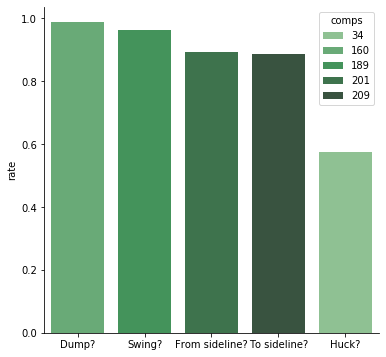

In [510]:
fig, ax = plt.subplots(figsize=(6,6))

throws = (full_poss_df.groupby(['Thrower error?'])
          [['Huck?','Swing?','Dump?','From sideline?','To sideline?']]
          .sum().T).rename(columns={0:'comps',1:'turns'})
throws['rate'] = 1 - (throws['turns'] / (throws['comps'] + throws['turns']))
throws = throws.sort_values('rate',ascending=False)

sns.despine(fig)
sns.barplot(x=throws.index,y=throws['rate'],hue=throws['comps'],palette='Greens_d',dodge=False)

plt.show()

<Figure size 504x288 with 0 Axes>

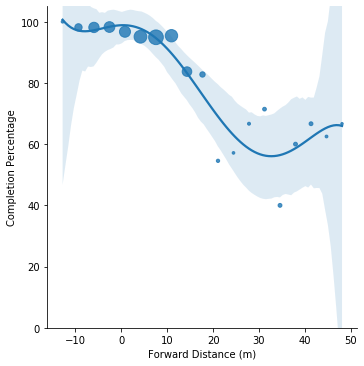

In [1053]:
#compare completion percentage with average throw gain
fig= plt.figure(figsize=(7,4))
sns.despine(fig)

#get list of pairs
df = full_poss_df.copy()
errors = (df.groupby(
    pd.cut(df['Forward distance (m)'],
           bins=len(np.arange(-20,70,4))))['Thrower error?'].sum())
total = (df.groupby(
    pd.cut(df['Forward distance (m)'],bins=len(np.arange(-20,70,4))))['Thrower error?'].size())
comps = ((1 - (errors/total)) * 100).round(2).reset_index()
comps['count'] = total.values
comps['dist'] = comps['Forward distance (m)'].apply(lambda x: x.left)
comps['Thrower error?'] = comps['Thrower error?'].fillna(0)

#everyone
line = sns.lmplot(data=comps[:-4],x='dist',y='Thrower error?',order=5,
                  scatter_kws={'s':comps['count']})

line.set(ylim=(0,105),ylabel='Completion Percentage',xlabel='Forward Distance (m)')
plt.show()

<Figure size 504x288 with 0 Axes>

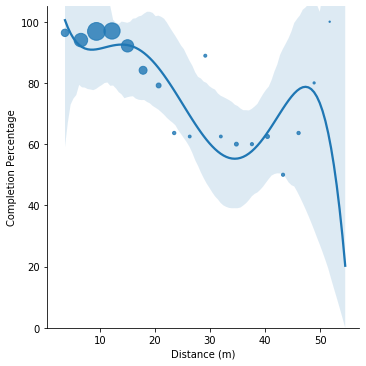

In [1052]:
#compare completion percentage with average throw gain
fig= plt.figure(figsize=(7,4))
sns.despine(fig)

#get list of pairs
df = full_poss_df.copy()
errors = (df.groupby(
    pd.cut(df['Distance (m)'],
           bins=len(np.arange(-20,70,4))))['Thrower error?'].sum())
total = (df.groupby(
    pd.cut(df['Distance (m)'],bins=len(np.arange(-20,70,4))))['Thrower error?'].size())
comps = ((1 - (errors/total)) * 100).round(2).reset_index()
comps['count'] = total.values
comps['dist'] = comps['Distance (m)'].apply(lambda x: x.left)
comps['Thrower error?'] = comps['Thrower error?'].fillna(0)

#everyone
line = sns.lmplot(data=comps[:-4],x='dist',y='Thrower error?',order=5,
                  scatter_kws={'s':comps['count']})

line.set(ylim=(0,105),ylabel='Completion Percentage',xlabel='Distance (m)')
plt.show()

### Plotting position on field

In [879]:
def draw_field_sns(endzoney_top=110,endzoney_bot=10):
    grid.fig.set_figwidth(4)
    grid.fig.set_figheight(11)

    c = 'k'
    grid.ax_joint.axvline(x=0,color=c)
    grid.ax_joint.axvline(x=1,color=c)
    grid.ax_joint.axhline(y=0,color=c)
    grid.ax_joint.axhline(y=.1818181818,color=c,zorder=0)
    grid.ax_joint.axhline(y=.8181818181,color=c,zorder=0)
    grid.ax_joint.axhline(y=1,color=c)

    #set x and yticks as yard markers every 10 yards
    xtick = .25/2
    ytick = .181818/2
    grid.ax_joint.set_xticks([xtick,xtick*2,xtick*3,xtick*4,xtick*5,xtick*6,xtick*7])
    grid.ax_joint.set_xticklabels([5,10,15,20,15,10,5])
    grid.ax_joint.set_yticks([ytick*2,ytick*3,ytick*4,ytick*5,ytick*6,ytick*7,ytick*8,ytick*9])
    grid.ax_joint.set_yticklabels([0,10,20,30,40,50,60,'Goal'])

    grid.ax_joint.set_xlabel('')
    grid.ax_joint.set_ylabel('Attacking --->',fontsize=16)

    #annotate endzones
    grid.ax_joint.text(.50,endzoney_top/120,'Scoring Endzone',
                       ha='center',va='center',
                       color='lightgray',alpha=.8,fontsize=18,zorder=0)
    grid.ax_joint.text(.50,endzoney_bot/120,'Defending Endzone',
                       ha='center',va='center',
                       color='lightgray',alpha=.8,fontsize=18,zorder=0)

<Figure size 240x660 with 0 Axes>

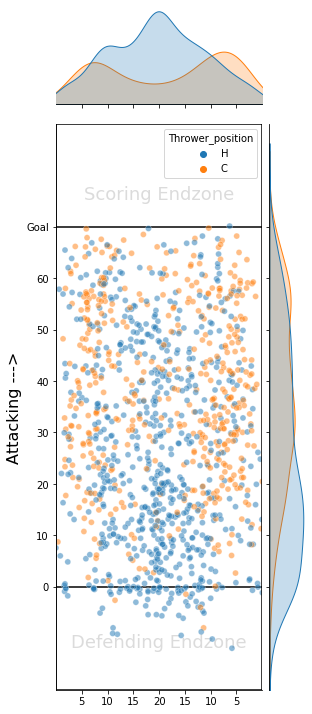

In [880]:
#All throws
fig = plt.figure(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()

x = df['Start X (0 -> 1 = left sideline -> right sideline)']
y = 1-df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']
hue = df['Thrower_position']

grid = sns.jointplot(x=x,y=y,marker='o',alpha=.5,hue=hue,xlim=[0,1],ylim=[0,1],marginal_ticks=False)

draw_field_sns(endzoney_top=105)

plt.show()

<Figure size 240x660 with 0 Axes>

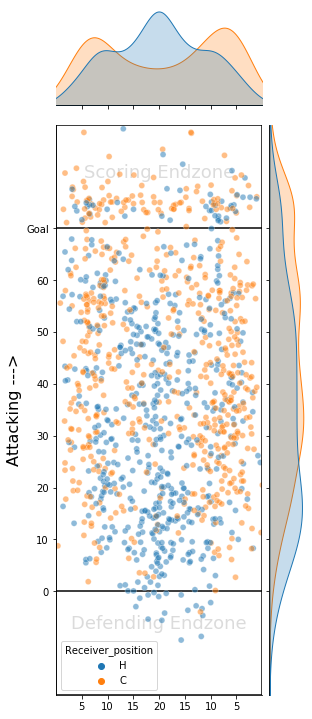

In [893]:
#All receptions
fig = plt.figure(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()

x = df['End X (0 -> 1 = left sideline -> right sideline)']
y = 1-df['End Y (0 -> 1 = back of opponent endzone -> back of own endzone)']
hue = df['Receiver_position']

grid = sns.jointplot(x=x,y=y,marker='o',alpha=.5,hue=hue,xlim=[0,1],ylim=[0,1])

draw_field_sns(endzoney_bot=15)

plt.show()

<Figure size 240x660 with 0 Axes>

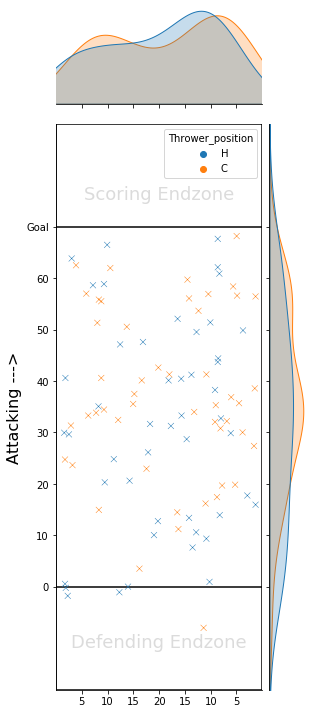

In [889]:
#All Turnovers
fig = plt.figure(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()
df = df[df['Thrower error?'] == 1]

x = df['Start X (0 -> 1 = left sideline -> right sideline)']
y = 1-df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']
hue = df['Thrower_position']

grid = sns.jointplot(x=x,y=y,marker='x',alpha=1,hue=hue,hue_order=['H','C'],xlim=[0,1],ylim=[0,1])

draw_field_sns(endzoney_top=105)

plt.show()

<Figure size 240x660 with 0 Axes>

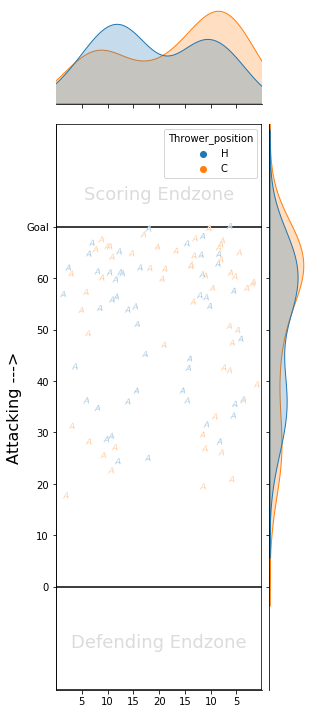

In [901]:
#All assists
fig = plt.figure(figsize=(4/1.2,11/1.2))

df = full_poss_df.copy()
df = df[df['Assist?'] == 1]

x = df['Start X (0 -> 1 = left sideline -> right sideline)']
y = 1-df['Start Y (0 -> 1 = back of opponent endzone -> back of own endzone)']
hue = df['Thrower_position']

grid = sns.jointplot(x=x,y=y,marker='$A$',alpha=1,hue=hue,hue_order=['H','C'],xlim=[0,1],ylim=[0,1])

draw_field_sns(endzoney_top=105)

plt.show()